In [1]:
import pandas as pd
import anndata as ad
from loguru import logger 
import time

import numpy as np
import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

import shapely
import geopandas as gpd

import os
import sys
sys.path.append(os.path.abspath('../scripts'))
import utils
import importlib

import scimap as sm

Running SCIMAP  2.1.3


In [2]:
sample_id = 991

path_to_quant = f"../data/quantification/{sample_id}_backsub_quantification.csv"
path_to_geojson = f"../data/geojsons/{sample_id}.geojson"
path_to_gates = "../data/phenotyping/20240911_gates.csv"

In [3]:
adata = utils.read_quant(path_to_quant)

2024-09-17 13:08:44.569 | INFO     | utils:read_quant:21 -  ---- read_quant : version number 1.0.0 ----
/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

2024-09-17 13:08:48.016 | INFO     | utils:read_quant:40 -  685805 cells and 75 variables
2024-09-17 13:08:48.022 | INFO     | utils:read_quant:41 -  ---- read_quant is done, took 3s  ----


2024-09-17 13:08:48.036 | INFO     | utils:filter_by_annotation:158 -  ---- filter_by_annotation : version number 1.1.0 ----
2024-09-17 13:08:48.175 | INFO     | utils:filter_by_annotation:164 - GeoJson loaded, detected: 17 annotations
2024-09-17 13:09:53.121 | INFO     | utils:filter_by_annotation:176 - Labelled cells with annotations if they were found inside


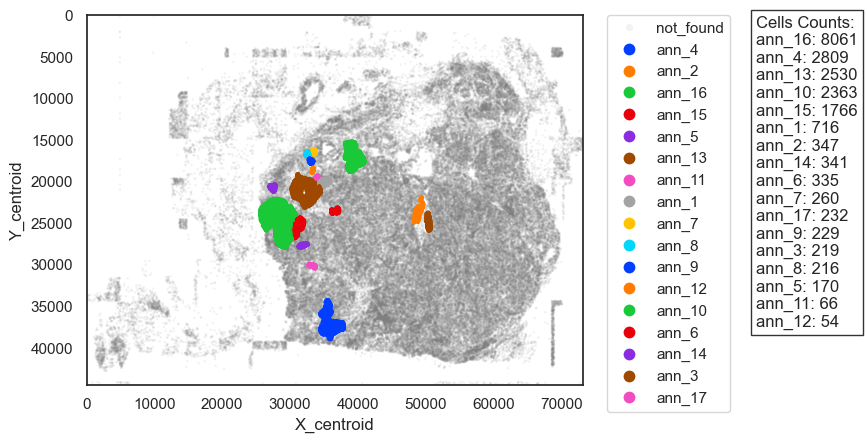

2024-09-17 13:09:54.027 | INFO     | utils:filter_by_annotation:208 -  ---- filter_by_annotation is done, took 65s  ----


In [4]:
adata = utils.filter_by_annotation(adata, path_to_geojson=path_to_geojson)

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

divide by zero encountered in log10



Threshold for DAPI intensity: 100.00
Threshold for DAPI intensity: 3162.28


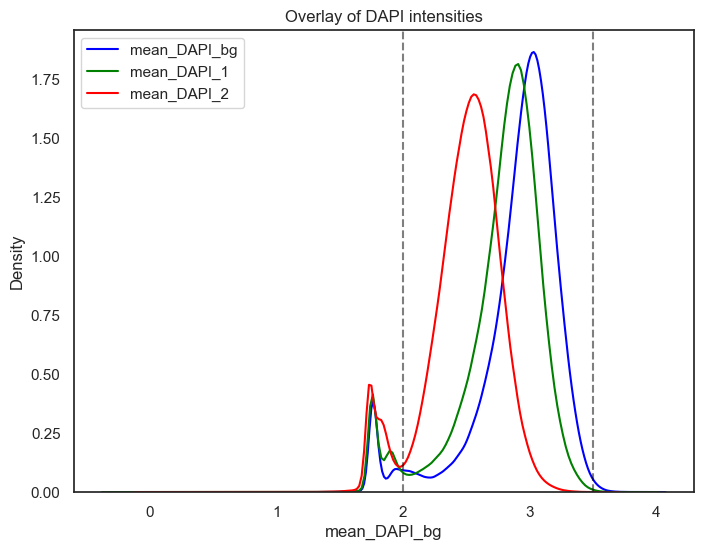

In [5]:
# Plot the density plot for each column
plt.figure(figsize=(8,6))
tmp_df = np.log10(pd.DataFrame(adata.X, columns=adata.var_names))
sns.kdeplot(tmp_df['mean_DAPI_bg'], label='mean_DAPI_bg', color='blue')
sns.kdeplot(tmp_df['mean_DAPI_1'], label='mean_DAPI_1', color='green')
sns.kdeplot(tmp_df['mean_DAPI_2'], label='mean_DAPI_2', color='red')

low_threshold = 2
plt.axvline(low_threshold, color='black', linestyle='--', alpha=0.5)
print(f"Threshold for DAPI intensity: {10**low_threshold:.2f}")

high_threshold = 3.5
plt.axvline(high_threshold, color='black', linestyle='--', alpha=0.5)
print(f"Threshold for DAPI intensity: {10**high_threshold:.2f}")

plt.title('Overlay of DAPI intensities')
plt.legend()
plt.show()

2024-09-17 13:09:56.849 | INFO     | utils:filter_by_abs_value:215 -  ---- filter_by_abs_value : version number 1.0.0 ----
2024-09-17 13:09:56.877 | INFO     | utils:filter_by_abs_value:231 - Number of cells with mean_DAPI_bg above 100: 653466


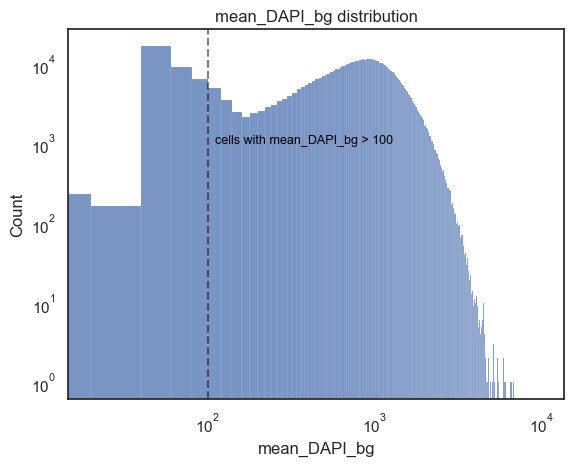

2024-09-17 13:09:57.605 | INFO     | utils:filter_by_abs_value:253 -  ---- filter_by_abs_value is done, took 0s  ----
2024-09-17 13:09:57.605 | INFO     | utils:filter_by_abs_value:215 -  ---- filter_by_abs_value : version number 1.0.0 ----
2024-09-17 13:09:57.631 | INFO     | utils:filter_by_abs_value:236 - Number of cells with mean_DAPI_bg below 3162: 683930


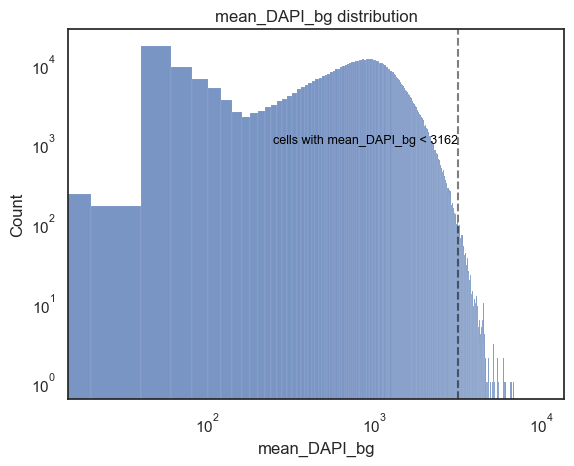

2024-09-17 13:09:58.240 | INFO     | utils:filter_by_abs_value:253 -  ---- filter_by_abs_value is done, took 0s  ----


In [6]:
adata = utils.filter_by_abs_value(adata=adata, marker="mean_DAPI_bg", value=100, direction="above")
adata = utils.filter_by_abs_value(adata=adata, marker="mean_DAPI_bg", value=3162, direction="below")

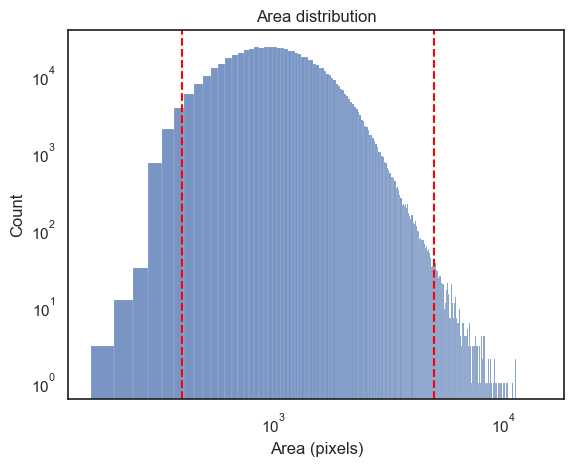

In [7]:
sns.histplot(adata.obs['Area'], bins=350)
plt.yscale('log')
plt.xscale('log')
plt.title('Area distribution')
plt.xlabel('Area (pixels)')
plt.axvline(400, color='red', linestyle='--')
plt.axvline(5000, color='red', linestyle='--')
plt.show()

In [8]:
adata.obs['Area_filter_nottoobig'] = adata.obs['Area'] < 5000
adata.obs['Area_filter_nottoolow'] = adata.obs['Area'] > 400
adata.obs['Area_filter'] = adata.obs['Area_filter_nottoobig'] & adata.obs['Area_filter_nottoolow']

#print stats
print("Number of cells before filtering: ", adata.shape[0])
print("Number of cells filtered out by Area: ", adata.shape[0] - adata.obs['Area_filter'].sum())
print("Percentage of cells filtered out by Area: ", round((adata.shape[0] - adata.obs['Area_filter'].sum())/adata.shape[0]*100, 3), "%")

Number of cells before filtering:  685805
Number of cells filtered out by Area:  6269
Percentage of cells filtered out by Area:  0.914 %


2024-09-17 13:09:58.859 | INFO     | utils:filter_by_ratio:111 -  ---- filter_by_ratio : version number 1.1.0 ----
2024-09-17 13:09:58.915 | INFO     | utils:filter_by_ratio:129 - Number of cells with DAPI ratio < 0.15: 20618
2024-09-17 13:09:58.947 | INFO     | utils:filter_by_ratio:130 - Number of cells with DAPI ratio > 1.05: 5125
2024-09-17 13:09:58.971 | INFO     | utils:filter_by_ratio:131 - Number of cells with DAPI ratio between 0.15 and 1.05: 659829
2024-09-17 13:09:58.996 | INFO     | utils:filter_by_ratio:132 - Percentage of cells filtered out: 3.79%


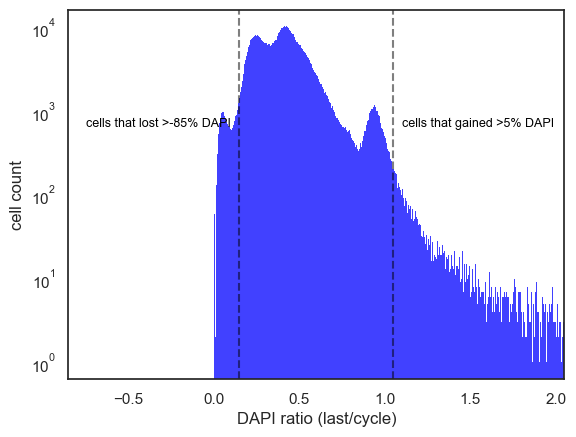

2024-09-17 13:10:01.471 | INFO     | utils:filter_by_ratio:152 -  ---- filter_by_ratio is done, took 2s  ----


In [9]:
adata = utils.filter_by_ratio(
    adata=adata, 
    end_cycle="mean_DAPI_2", 
    start_cycle="mean_DAPI_bg", 
    label="DAPI",
    min_ratio=0.15,
    max_ratio=1.05,
    )

In [10]:
adata = adata[adata.obs['filter_by_ann'].astype(bool) & adata.obs['mean_DAPI_bg_abs_below_value'] & adata.obs['mean_DAPI_bg_abs_above_value'] & adata.obs['Area_filter'] & adata.obs['DAPI_ratio_pass']]

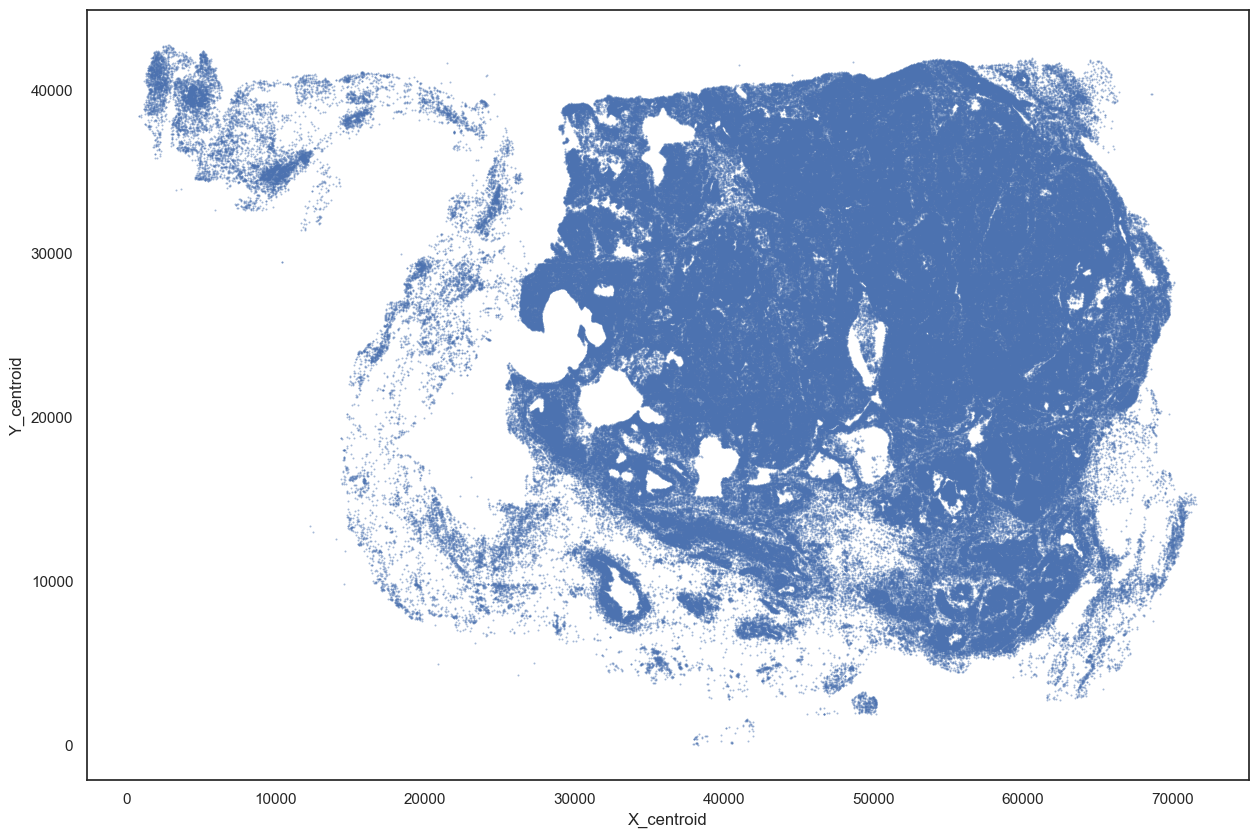

In [11]:
sns.scatterplot(data=adata.obs, x='X_centroid', y='Y_centroid', linewidth=0, s=2, alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(15, 10)

In [12]:
gates = utils.read_gates(path_to_gates)
gates = gates[gates['sample_id']==991]
adata.obs['imageid'] = "991"
gates_990 = utils.process_gates_for_sm(gates, sample_id="991")

2024-09-17 13:10:02.305 | INFO     | utils:read_gates:48 -  ---- read_gates : version number 1.0.0 ----
2024-09-17 13:10:02.320 | INFO     | utils:read_gates:53 -    Filtering out all rows with value 0.0 (assuming not gated)
2024-09-17 13:10:02.321 | INFO     | utils:read_gates:56 -   Found 78 valid gates
2024-09-17 13:10:02.322 | INFO     | utils:read_gates:58 -  ---- read_gates is done, took 0s  ----
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_95993/3461051388.py:3: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

2024-09-17 13:10:02.575 | INFO     | utils:process_gates_for_sm:77 -  ---- process_gates_for_sm : version number 1.0.0 ----
/Users/jnimoca/Jose_BI/P26_DA/scripts/utils.py:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2

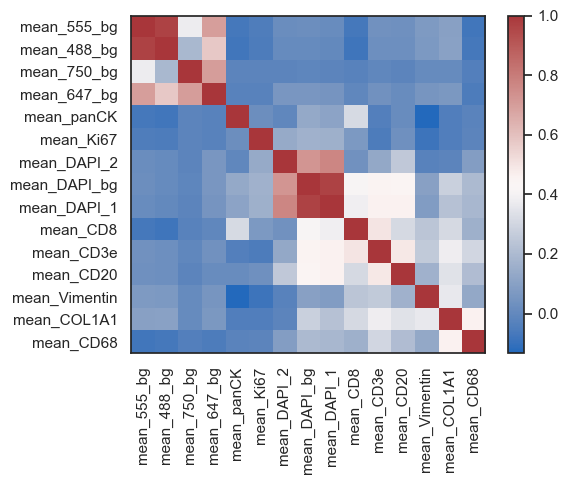

In [13]:
adata = adata[:, adata.var_names.str.contains("mean")]
sm.pl.markerCorrelation(adata, figsize=(6,5), layer=None)

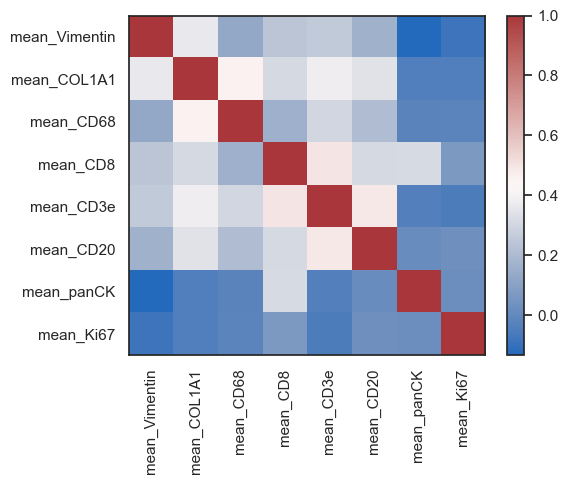

In [14]:
#remove not gated channels
adata = adata[:, adata.var_names.isin(gates_990['marker'])]
sm.pl.markerCorrelation(adata, figsize=(6,5), layer=None)

In [15]:
adata.raw = adata
adata = sm.pp.log1p(adata)

In [16]:
adata = sm.pp.rescale(adata, gate=gates_990, log=True, verbose=True)

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/preprocessing/rescale.py:105: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Scaling Image 991
Scaling mean_Vimentin
Scaling mean_CD3e
Scaling mean_panCK
Scaling mean_CD8
Scaling mean_COL1A1
Scaling mean_CD20
Scaling mean_CD68
Scaling mean_Ki67


In [17]:
path_to_phenotype_matrix = "../data/phenotyping/20240905_PhenotypeMatrix_v3.csv"
phenotype_matrix = pd.read_csv(path_to_phenotype_matrix)

In [18]:
adata = sm.tl.phenotype_cells (adata, phenotype=phenotype_matrix, label="phenotype") 

Phenotyping Cancer_cells
Phenotyping T_cells
Phenotyping Vimentin_cells
Phenotyping COL1A1_cells
Phenotyping B_cells
Phenotyping Macrophages
-- Subsetting T_cells
Phenotyping CD4_Tcells
Phenotyping CD8_Tcells
Consolidating the phenotypes across all groups


/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [19]:
adata.obs.phenotype.value_counts()

phenotype
Unknown           270447
Cancer_cells      171405
CD4_Tcells         72486
COL1A1_cells       54139
CD8_Tcells         29065
Vimentin_cells      8254
B_cells             3067
Macrophages         1319
Name: count, dtype: int64

In [20]:
custom_colours = {
    "Cancer_cells" : "red",
    "CD4_Tcells" : "peru",
    "CD8_Tcells" : "lawngreen",
    "Macrophages" : "yellow",
    "COL1A1_cells" : "deepskyblue",
    "Vimentin_cells" : "orange",
    "B_cells" : "black",
    "Unknown" : "whitesmoke"
}

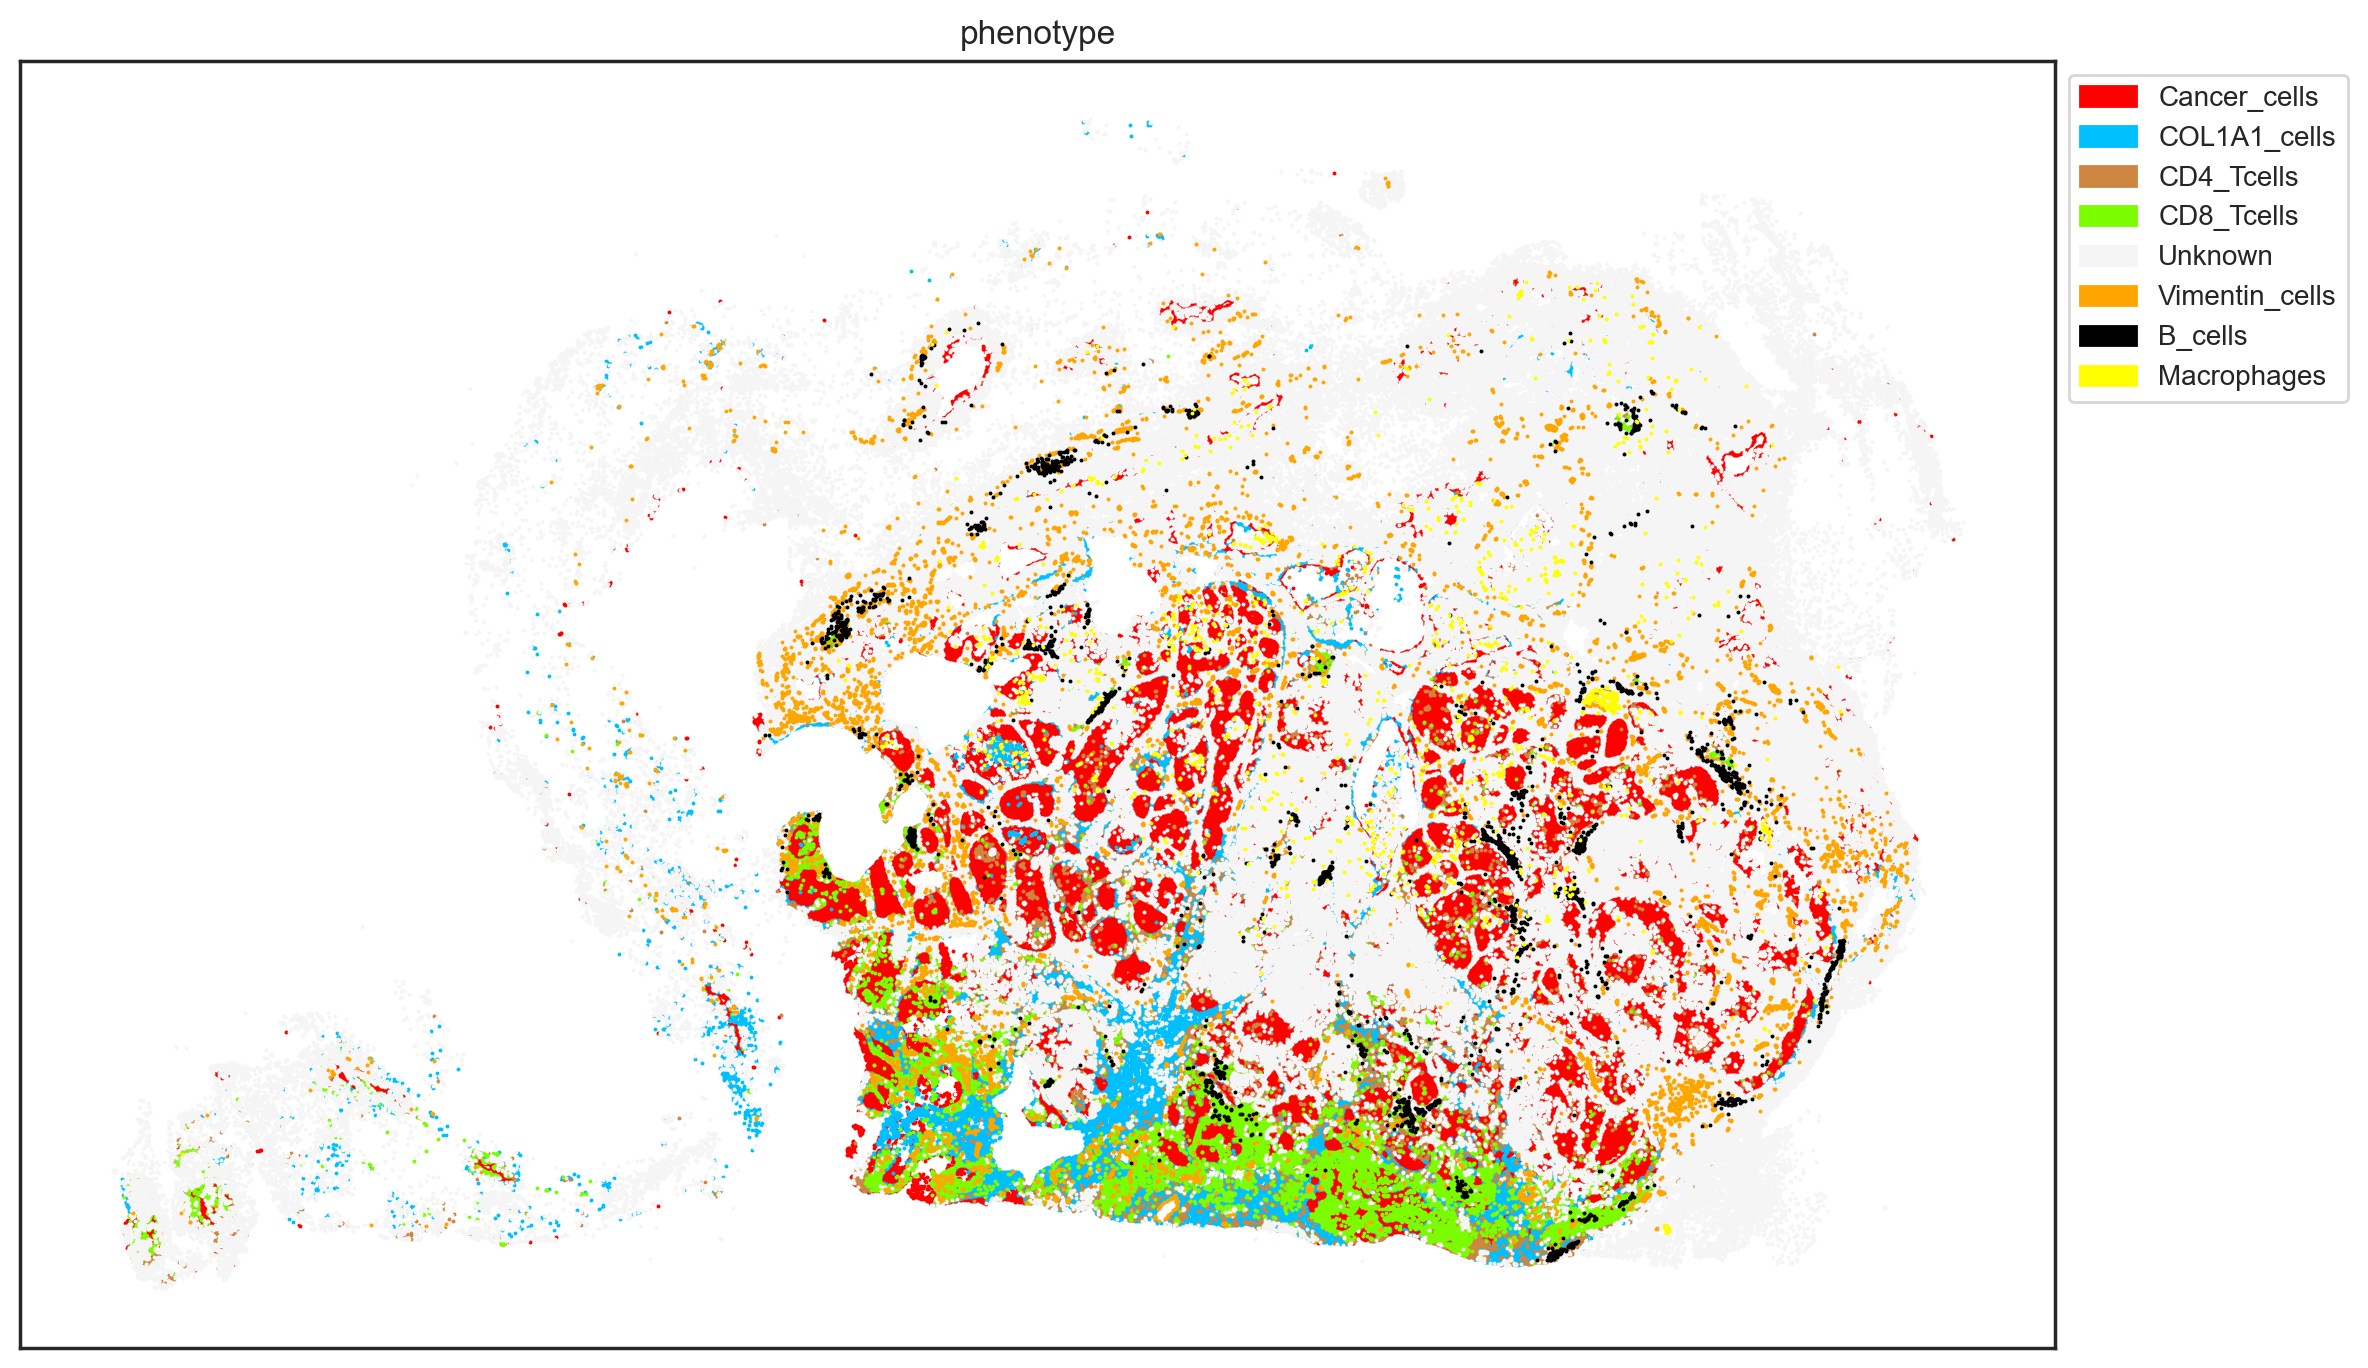

In [21]:
sm.pl.spatial_scatterPlot (adata, colorBy = ['phenotype'],figsize=(12,7), s=2, fontsize=10, customColors=custom_colours)

In [22]:
adata.write(f"../data/processed/{sample_id}_phenotyped.h5ad")